In [1]:
# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats


# holt winters 
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
# consistent plot size wherever not specifiied
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

# Menekan warning yang tidak perlu
warnings.filterwarnings('ignore')

In [2]:
# BKKG Preprocessing 
bmkg_data = pd.read_csv('/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/BMKG/Stasiun Klimatologi Aceh/CSV/BMKG_Data_All.csv', index_col=0,parse_dates=True)

In [3]:
# Print 20 data teratas
bmkg_data.head(20)

,Year,Month,Day,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
Date,,,,,,,,,,,,,
2005-01-01,2005,1,1,21,33.2,25.7,90,8888,5.0,-,-,-,-
2005-01-02,2005,1,2,22,33,26.3,90,8888,0.0,-,-,-,-
2005-01-03,2005,1,3,21,33,26.5,90,8888,3.0,-,-,-,-
2005-01-04,2005,1,4,22,33,26.5,89,2,3.1,-,-,-,-
2005-01-05,2005,1,5,21,32.8,25.6,88,8888,7.5,-,-,-,-
2005-01-06,2005,1,6,22,32,27.1,89,8888,5.0,-,-,-,-
2005-01-07,2005,1,7,21,32.4,27.5,89,4,5.0,-,-,-,-
2005-01-08,2005,1,8,22,33,26.6,90,8888,0.0,-,-,-,-
2005-01-09,2005,1,9,21,33,25.7,91,8888,2.4,-,-,-,-


In [4]:
# Check tipe data 
print(bmkg_data.dtypes)

Year        int64
Month       int64
Day         int64
TN         object
TX         object
TAVG       object
RH_AVG     object
RR         object
SS         object
FF_X       object
DDD_X      object
FF_AVG     object
DDD_CAR    object
dtype: object


In [5]:
# List kolom yang harus diperbaiki, kecuali DDD_CAR karena wind direction
cols_to_fix = ['TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS', 'FF_X', 'DDD_X', 'FF_AVG']

# Bersihkan: ganti '-' jadi NaN, lalu convert ke numeric
for col in cols_to_fix:
    bmkg_data[col] = pd.to_numeric(bmkg_data[col], errors='coerce')
print(bmkg_data.dtypes)

Year         int64
Month        int64
Day          int64
TN         float64
TX         float64
TAVG       float64
RH_AVG     float64
RR         float64
SS         float64
FF_X       float64
DDD_X      float64
FF_AVG     float64
DDD_CAR     object
dtype: object


In [6]:
# Menangani nilai 8888 dan 9999 (kode untuk missing value)
for col in bmkg_data.columns:
    if bmkg_data[col].dtype != 'object':  # Hanya ubah kolom numerik
        bmkg_data[col] = bmkg_data[col].replace([8888, 9999], np.nan)

In [ ]:
# Mengecek persentase missing values di setiap kolom
missing_percentage = bmkg_data.isna().mean() * 100
print("Persentase Missing Values per Kolom:")
print(missing_percentage)

Persentase Missing Values per Kolom:
Year        0.000000
Month       0.000000
Day         0.000000
TN          1.052905
TX          0.779930
TAVG        0.103991
RH_AVG      0.025998
RR         36.747693
SS          0.740933
FF_X        1.390875
DDD_X       4.952554
FF_AVG      7.357338
DDD_CAR     0.000000
dtype: float64


In [10]:
# Menampilkan data setelah penanganan missing values
print("\nData setelah penanganan missing values:")
print(bmkg_data.head())


Data setelah penanganan missing values:
            Year  Month  Day    TN    TX  TAVG  RH_AVG   RR   SS  FF_X  DDD_X  \
Date                                                                            
2005-01-01  2005      1    1  21.0  33.2  25.7    90.0  NaN  5.0   NaN    NaN   
2005-01-02  2005      1    2  22.0  33.0  26.3    90.0  NaN  0.0   NaN    NaN   
2005-01-03  2005      1    3  21.0  33.0  26.5    90.0  NaN  3.0   NaN    NaN   
2005-01-04  2005      1    4  22.0  33.0  26.5    89.0  2.0  3.1   NaN    NaN   
2005-01-05  2005      1    5  21.0  32.8  25.6    88.0  NaN  7.5   NaN    NaN   

            FF_AVG DDD_CAR  
Date                        
2005-01-01     NaN       -  
2005-01-02     NaN       -  
2005-01-03     NaN       -  
2005-01-04     NaN       -  
2005-01-05     NaN       -  


In [11]:
# Memilih kolom numerik untuk smoothing (exclude DDD_CAR karena arah mata angin)
numeric_cols = bmkg_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'DDD_CAR' in numeric_cols:
    numeric_cols.remove('DDD_CAR')

In [12]:
# Fungsi untuk menerapkan SMA (Simple Moving Average)
def apply_sma(series, window):
    return series.rolling(window=window).mean()

# Fungsi untuk menerapkan EWMA (Exponentially Weighted Moving Average)
def apply_ewma(series, span):
    return series.ewm(span=span).mean()

# Memilih beberapa kolom untuk visualisasi (contoh: TAVG, RH_AVG)
columns_to_visualize = ['RH_AVG']

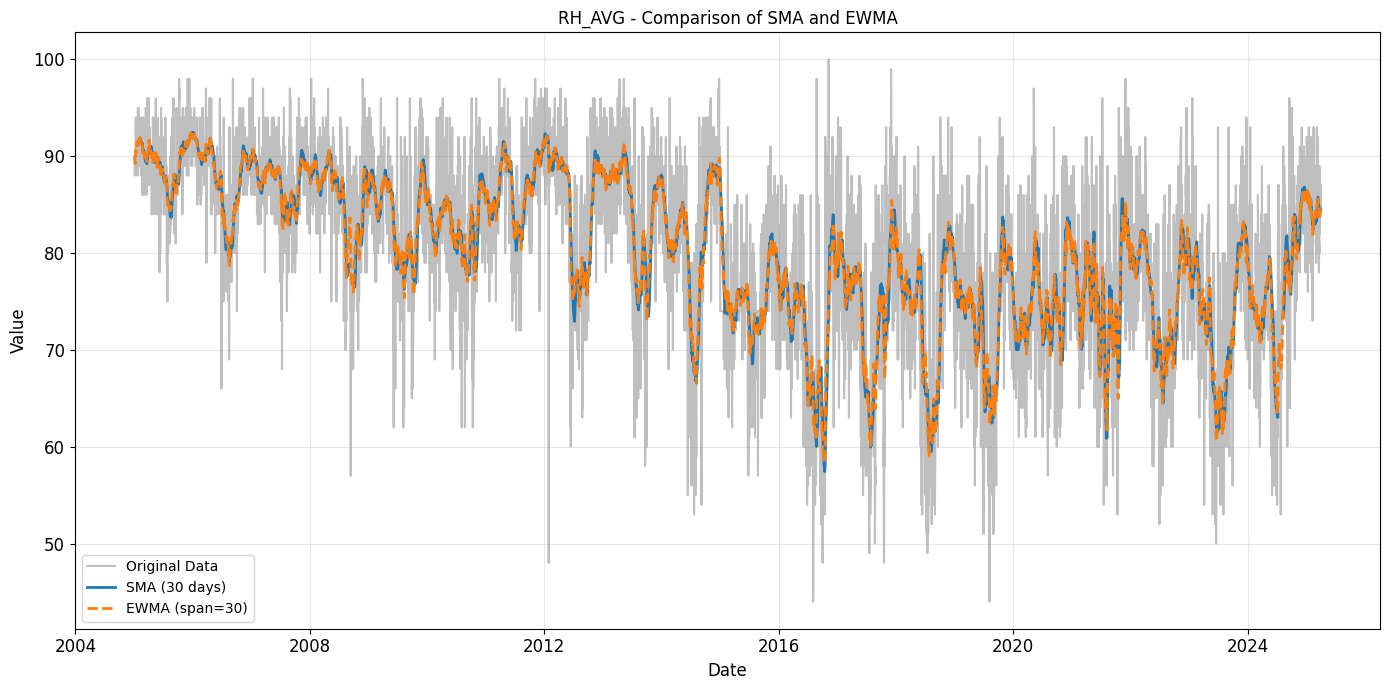

In [13]:
# Menerapkan SMA dan EWMA pada kolom yang dipilih
for col in columns_to_visualize:
    plt.figure(figsize=(14, 7))
    
    # Data asli
    plt.plot(bmkg_data.index, bmkg_data[col], label='Original Data', color='gray', alpha=0.5)
    
    # SMA dengan berbagai windows
    for window in [30]:
        sma = apply_sma(bmkg_data[col], window)
        plt.plot(bmkg_data.index, sma, label=f'SMA ({window} days)', linewidth=2)
    
    # EWMA dengan berbagai spans
    for span in [30]:
        ewma = apply_ewma(bmkg_data[col], span)
        plt.plot(bmkg_data.index, ewma, label=f'EWMA (span={span})', linestyle='--', linewidth=2)
    
    plt.grid(True, alpha=0.3)
    plt.title(f'{col} - Comparison of SMA and EWMA')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

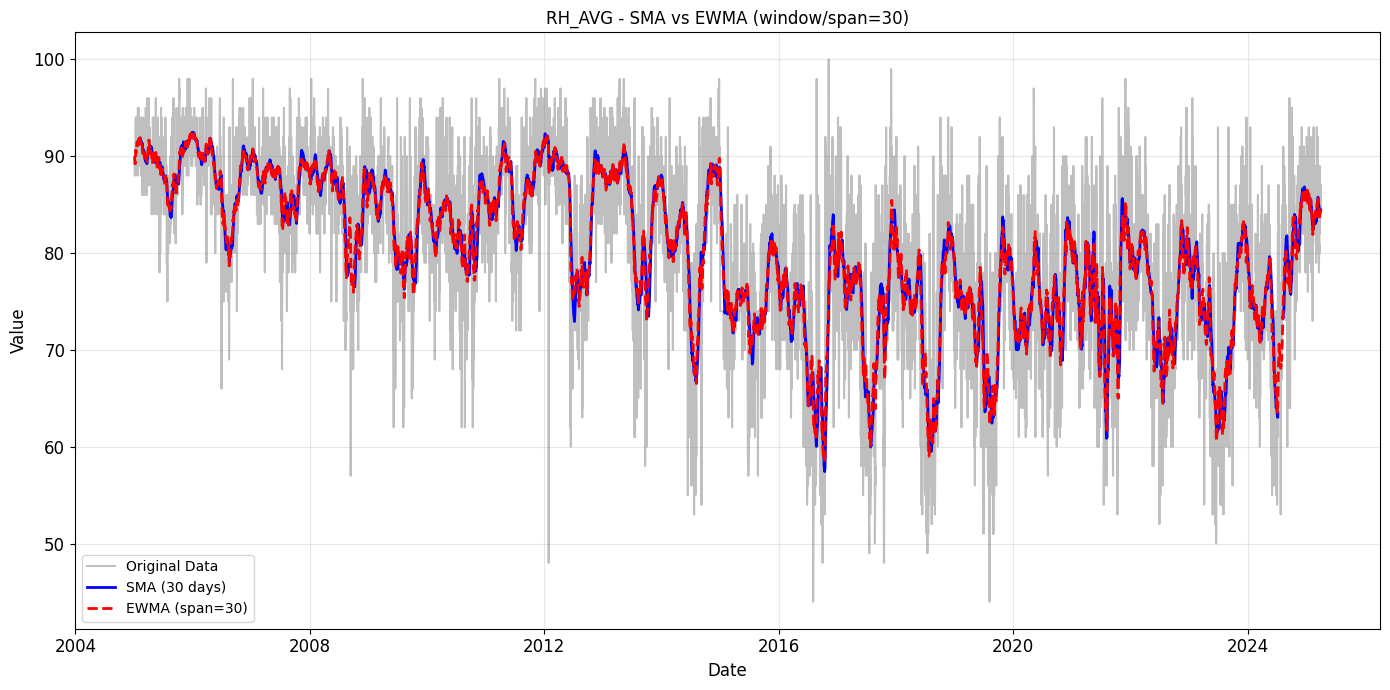

In [14]:
# Membandingkan SMA dan EWMA pada satu kolom (misalnya RH_AVG)
col_to_compare = 'RH_AVG'
window_size = 30
span_value = 30

plt.figure(figsize=(14, 7))
plt.plot(bmkg_data.index, bmkg_data[col_to_compare], label='Original Data', color='gray', alpha=0.5)
plt.plot(bmkg_data.index, apply_sma(bmkg_data[col_to_compare], window_size), 
         label=f'SMA ({window_size} days)', color='blue', linewidth=2)
plt.plot(bmkg_data.index, apply_ewma(bmkg_data[col_to_compare], span_value), 
         label=f'EWMA (span={span_value})', color='red', linewidth=2, linestyle='--')

plt.grid(True, alpha=0.3)
plt.title(f'{col_to_compare} - SMA vs EWMA (window/span={window_size})')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Analisis residual untuk melihat kualitas smoothing
col_for_residual = 'RH_AVG'
window_size = 30
span_value = 30

sma_values = apply_sma(bmkg_data[col_for_residual], window_size)
ewma_values = apply_ewma(bmkg_data[col_for_residual], span_value)

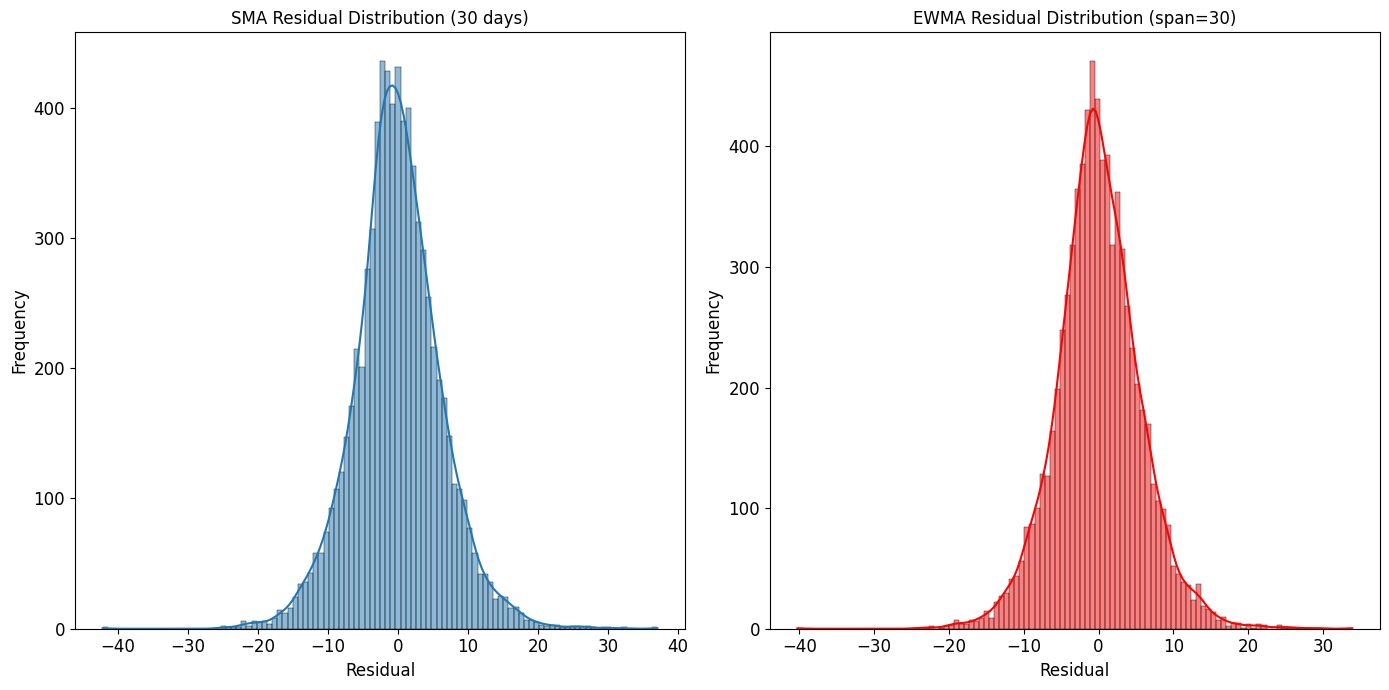

In [16]:
# Hitung residual (selisih antara data asli dan hasil smoothing)
sma_residual = bmkg_data[col_for_residual] - sma_values
ewma_residual = bmkg_data[col_for_residual] - ewma_values

# Menampilkan distribusi residual
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(sma_residual.dropna(), kde=True, label='SMA Residual')
plt.title(f'SMA Residual Distribution ({window_size} days)')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(ewma_residual.dropna(), kde=True, color='red', label='EWMA Residual')
plt.title(f'EWMA Residual Distribution (span={span_value})')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
# 1. Imputasi Missing Values untuk analisis time series
# Menggunakan forward fill dan backward fill untuk data yang akan dianalisis
bmkg_data_filled = bmkg_data.fillna(method='ffill').fillna(method='bfill')

In [18]:
# 2. Time Series Decomposition dengan HP Filter
# Pilih kolom untuk dekomposisi
col_for_decomp = 'RH_AVG'

In [19]:
# Menerapkan HP Filter (lambda=1600 adalah standar untuk data kuartalan)
# Untuk data harian, nilai lambda yang lebih besar seperti 129600 bisa digunakan
cycle, trend = hpfilter(bmkg_data_filled[col_for_decomp], lamb=250000)

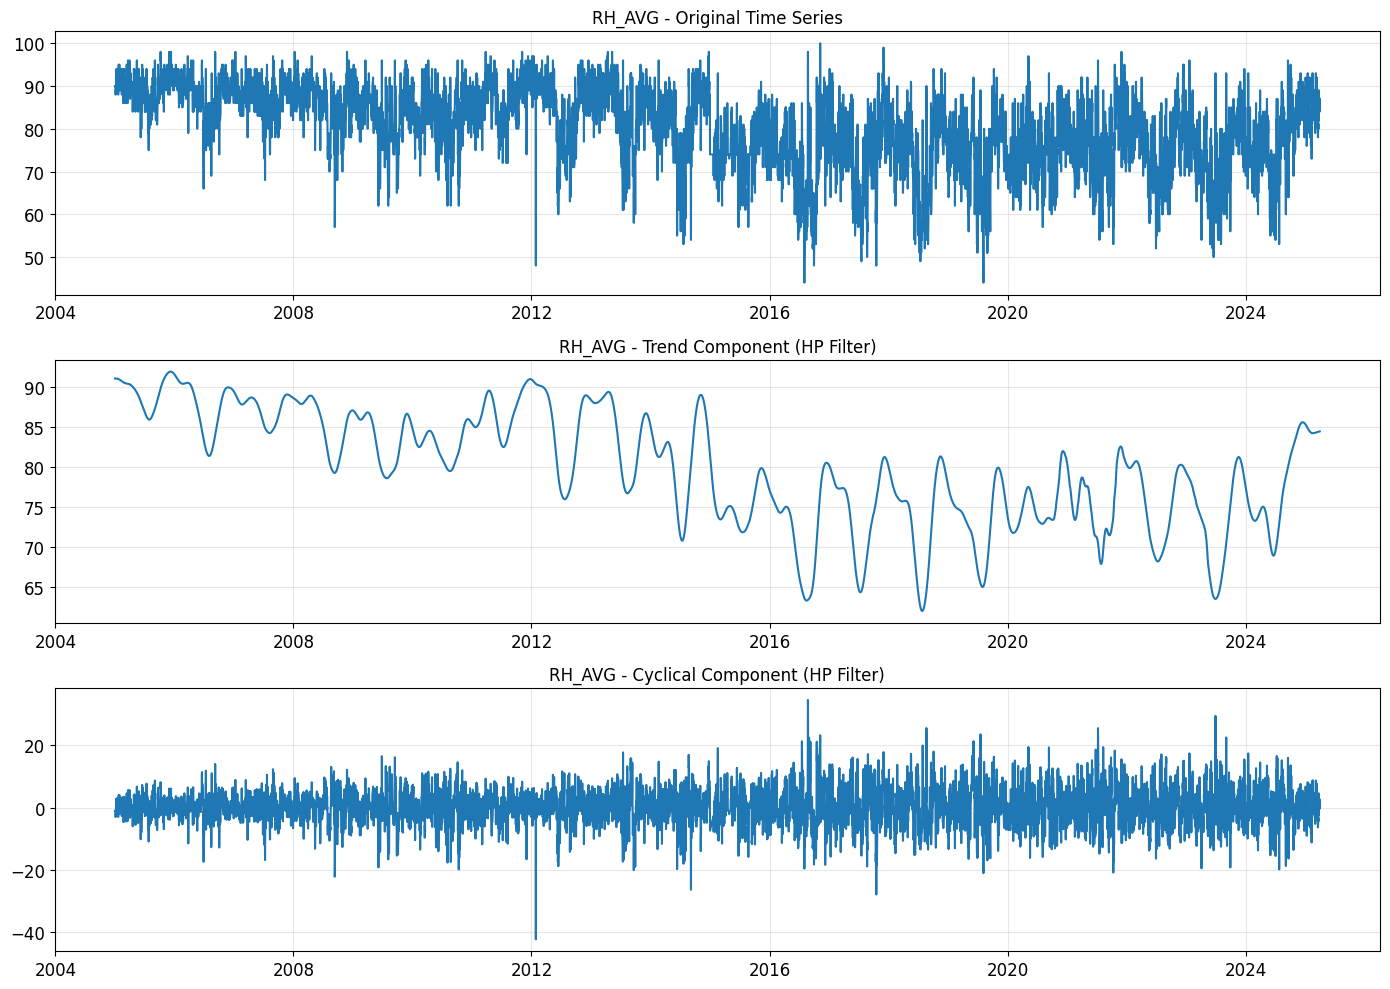

In [20]:
# Visualisasi hasil dekomposisi HP Filter
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp])
plt.title(f'{col_for_decomp} - Original Time Series')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(bmkg_data_filled.index, trend)
plt.title(f'{col_for_decomp} - Trend Component (HP Filter)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(bmkg_data_filled.index, cycle)
plt.title(f'{col_for_decomp} - Cyclical Component (HP Filter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


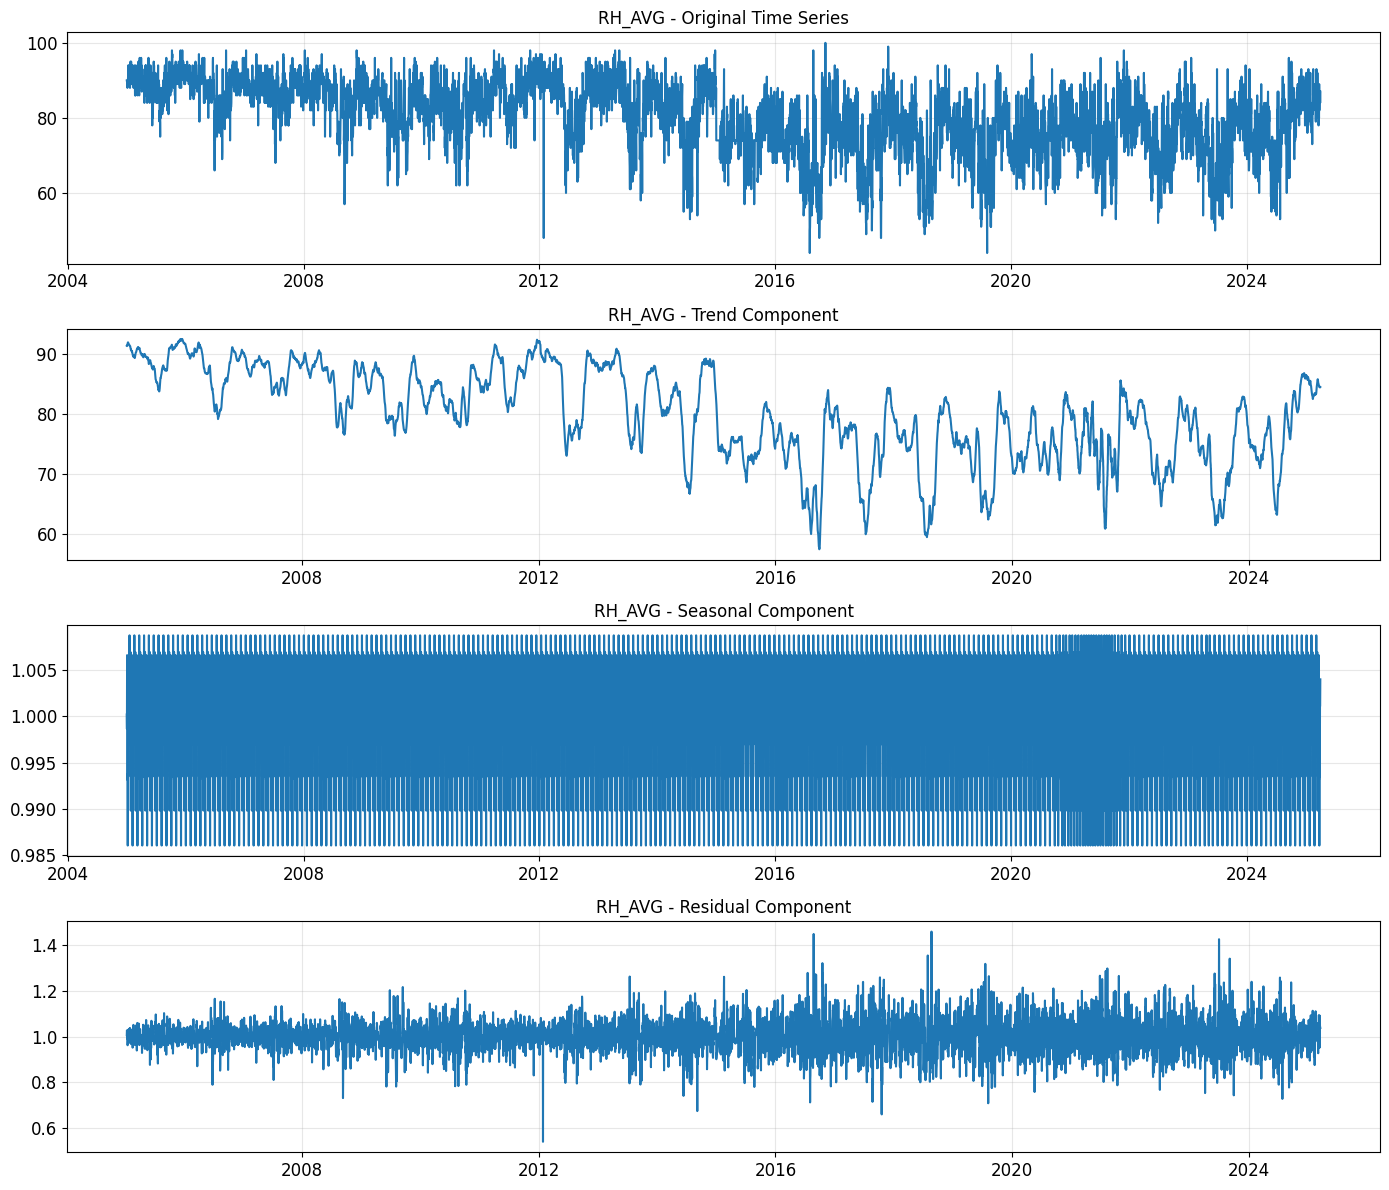

In [21]:
# 3. Seasonal Decomposition (alternatif HP Filter)
# Seasonal decomposition menggunakan model additive

# Apa beda multiplikatif dan aditive?
decomposition = seasonal_decompose(bmkg_data_filled[col_for_decomp], model='multiplicative', period=30)


# Visualisasi hasil seasonal decomposition
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp])
plt.title(f'{col_for_decomp} - Original Time Series')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(bmkg_data_filled.index, decomposition.trend)
plt.title(f'{col_for_decomp} - Trend Component')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(bmkg_data_filled.index, decomposition.seasonal)
plt.title(f'{col_for_decomp} - Seasonal Component')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(bmkg_data_filled.index, decomposition.resid)
plt.title(f'{col_for_decomp} - Residual Component')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Triple Exponential Smoothing (Holt-Winters Method) - Multiplicative
print("\n=== Triple Exponential Smoothing (Holt-Winters Method) ===")


# Daftar seasonal periods yang akan dicoba
seasonal_periods_list = [7, 30, 365]  # Mingguan, bulanan, tahunan
tes_models = {}
tes_fitted_values = {}
tes_mse_dict = {}


=== Triple Exponential Smoothing (Holt-Winters Method) ===


In [23]:
for seasonal_period in seasonal_periods_list:
    try:
        print(f"\nAnalisis dengan seasonal period: {seasonal_period}")
        tes_model = ExponentialSmoothing(
            bmkg_data_filled[col_for_decomp],
            trend='add',       # Menggunakan trend aditif
            seasonal='mul',    # Menggunakan seasonal multiplicative
            seasonal_periods=seasonal_period
        ).fit(optimized=True, remove_bias=True)
        
        # Simpan model dan fitted values
        tes_models[seasonal_period] = tes_model
        tes_fitted_values[seasonal_period] = tes_model.fittedvalues
        
        # Hitung MSE
        tes_mse = mean_squared_error(bmkg_data_filled[col_for_decomp], tes_model.fittedvalues)
        tes_mse_dict[seasonal_period] = tes_mse
        
        # Cetak parameter optimum
        print(f"Optimal Alpha (level): {tes_model.params['smoothing_level']:.4f}")
        print(f"Optimal Beta (trend): {tes_model.params['smoothing_trend']:.4f}")
        print(f"Optimal Gamma (seasonal): {tes_model.params['smoothing_seasonal']:.4f}")
        print(f"Mean Squared Error: {tes_mse:.4f}")
        
    except Exception as e:
        print(f"Error dengan seasonal period {seasonal_period}: {str(e)}")


Analisis dengan seasonal period: 7
Optimal Alpha (level): 0.4343
Optimal Beta (trend): 0.0001
Optimal Gamma (seasonal): 0.0251
Mean Squared Error: 28.6338

Analisis dengan seasonal period: 30
Optimal Alpha (level): 0.4295
Optimal Beta (trend): 0.0002
Optimal Gamma (seasonal): 0.0272
Mean Squared Error: 28.5654

Analisis dengan seasonal period: 365
Optimal Alpha (level): 0.4298
Optimal Beta (trend): 0.0002
Optimal Gamma (seasonal): 0.0543
Mean Squared Error: 28.1375



Periode seasonal terbaik berdasarkan MSE: 365
MSE: 28.1375


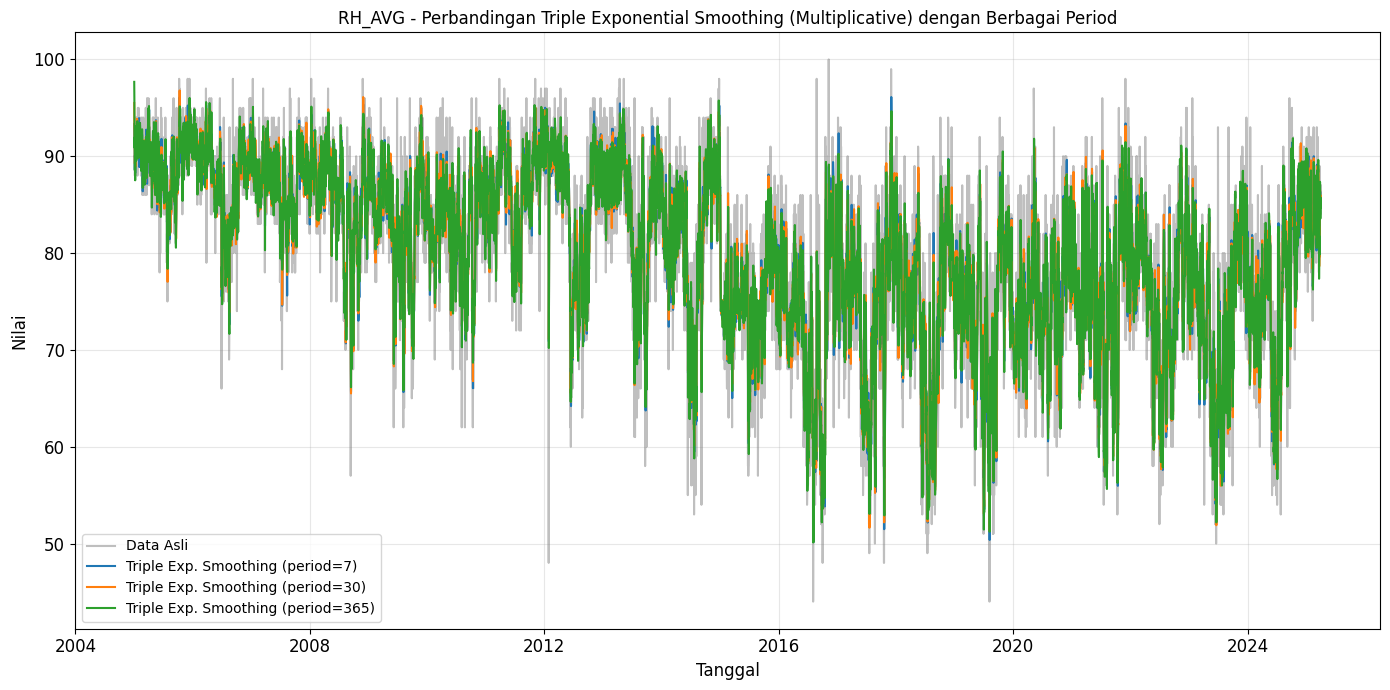

In [24]:
# Temukan seasonal period terbaik berdasarkan MSE
best_period = None
if tes_mse_dict:
    best_period = min(tes_mse_dict, key=tes_mse_dict.get)
    print(f"\nPeriode seasonal terbaik berdasarkan MSE: {best_period}")
    print(f"MSE: {tes_mse_dict[best_period]:.4f}")

# Visualisasi perbandingan fitted values untuk setiap seasonal period
plt.figure(figsize=(14, 7))

# Data asli
plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp], 
         label='Data Asli', color='gray', alpha=0.5)

# Triple Exponential Smoothing untuk setiap seasonal period
for period, fitted in tes_fitted_values.items():
    plt.plot(bmkg_data_filled.index, fitted, 
             label=f'Triple Exp. Smoothing (period={period})', 
             linewidth=1.5)

plt.grid(True, alpha=0.3)
plt.title(f'{col_for_decomp} - Perbandingan Triple Exponential Smoothing (Multiplicative) dengan Berbagai Period')
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Evaluasi model terbaik dengan berbagai metrik
def evaluate_model(actual, fitted, model_name):
    # Hapus NaN values
    valid_idx = ~np.isnan(fitted) & ~np.isnan(actual)
    actual_valid = actual[valid_idx]
    fitted_valid = fitted[valid_idx]
    
    if len(actual_valid) == 0:
        print(f"{model_name}: Tidak cukup data valid untuk evaluasi")
        return None
    
    mse = mean_squared_error(actual_valid, fitted_valid)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_valid, fitted_valid)
    r2 = r2_score(actual_valid, fitted_valid)
    
    print(f"\n{model_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}



Triple Exponential Smoothing (period=365):
  Mean Squared Error (MSE): 28.1375
  Root Mean Squared Error (RMSE): 5.3045
  Mean Absolute Error (MAE): 3.9714
  R-squared (R²): 0.6842


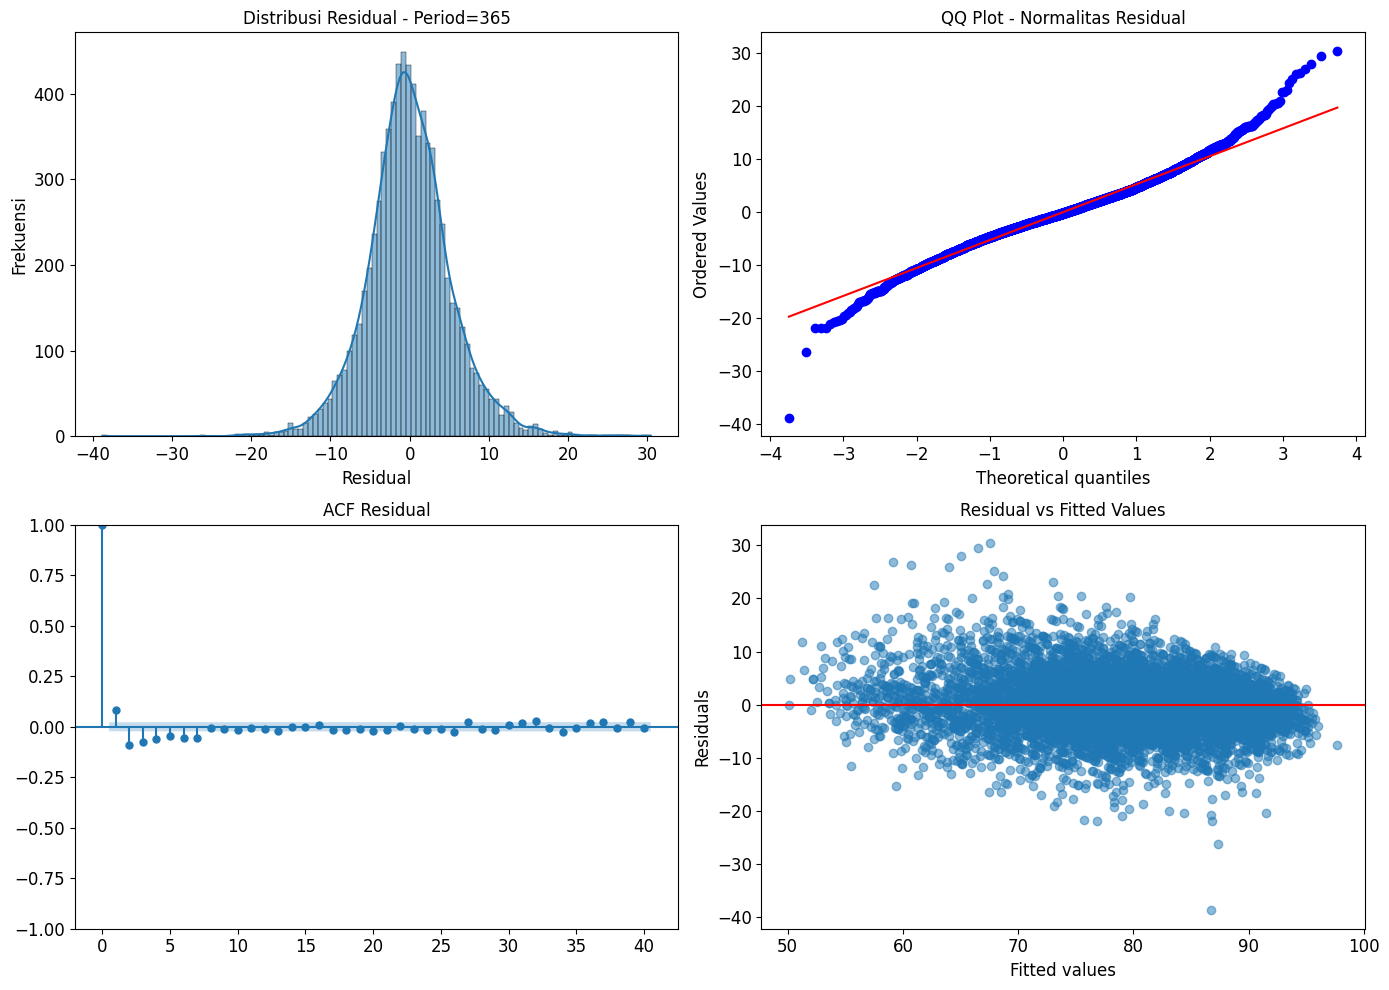

In [26]:
# Evaluasi model terbaik
if best_period:
    best_model = tes_models[best_period]
    best_fitted = tes_fitted_values[best_period]
    results = evaluate_model(
        bmkg_data_filled[col_for_decomp], 
        best_fitted, 
        f"Triple Exponential Smoothing (period={best_period})"
    )

# Analisis residual untuk model terbaik
if best_period:
    residuals = bmkg_data_filled[col_for_decomp] - best_fitted
    
    plt.figure(figsize=(14, 10))
    
    # Histogram residual
    plt.subplot(2, 2, 1)
    sns.histplot(residuals.dropna(), kde=True)
    plt.title(f'Distribusi Residual - Period={best_period}')
    plt.xlabel('Residual')
    plt.ylabel('Frekuensi')
    
    # QQ plot
    plt.subplot(2, 2, 2)
    stats.probplot(residuals.dropna(), plot=plt)
    plt.title('QQ Plot - Normalitas Residual')
    
    # Plot ACF dari residual
    plt.subplot(2, 2, 3)
    plot_acf(residuals.dropna(), lags=40, alpha=0.05, ax=plt.gca())
    plt.title('ACF Residual')
    
    # Residual vs fitted
    plt.subplot(2, 2, 4)
    plt.scatter(best_fitted, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residual vs Fitted Values')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()


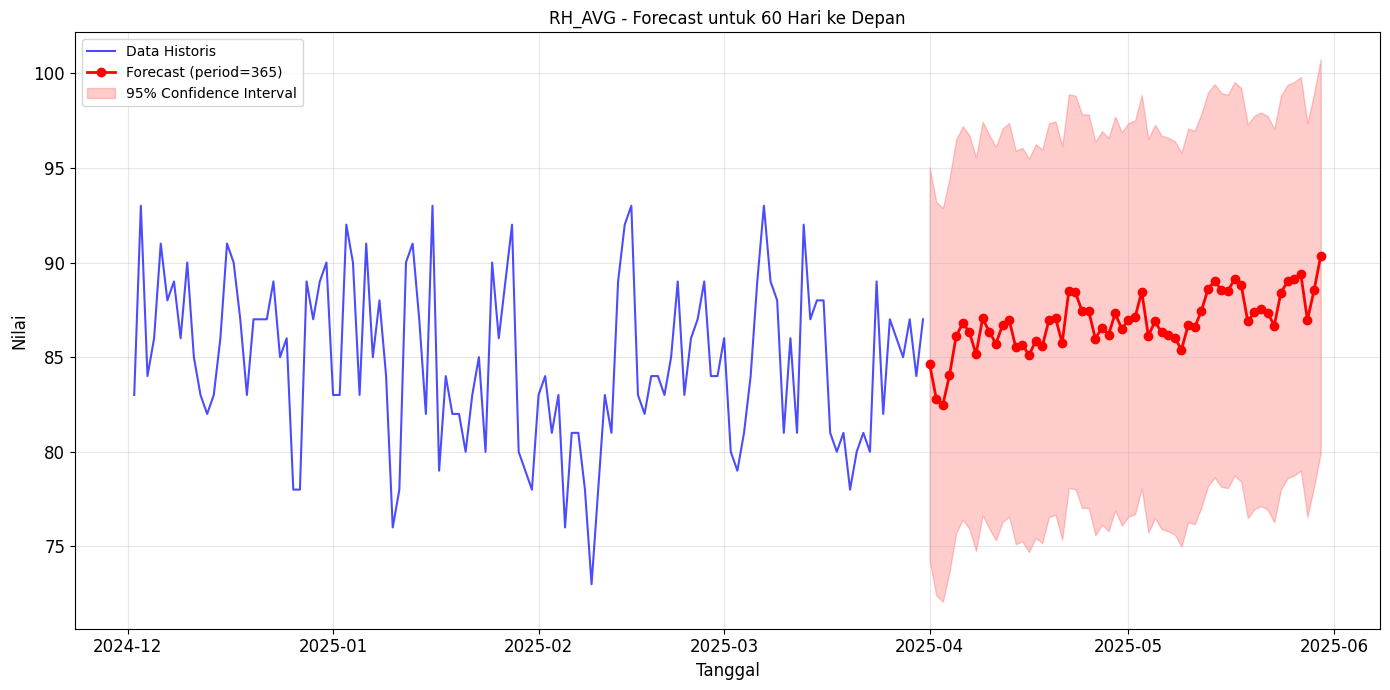


Hasil Forecast untuk 30 hari ke depan:
        Tanggal  Forecast_RH_AVG
7693 2025-04-01        84.634667
7694 2025-04-02        82.812747
7695 2025-04-03        82.479868
7696 2025-04-04        84.047300
7697 2025-04-05        86.097207
7698 2025-04-06        86.804352
7699 2025-04-07        86.322097
7700 2025-04-08        85.155712
7701 2025-04-09        87.045773
7702 2025-04-10        86.342180
7703 2025-04-11        85.711594
7704 2025-04-12        86.682808
7705 2025-04-13        86.972505
7706 2025-04-14        85.514880
7707 2025-04-15        85.658127
7708 2025-04-16        85.099303
7709 2025-04-17        85.852366
7710 2025-04-18        85.573207
7711 2025-04-19        86.954704
7712 2025-04-20        87.065258
7713 2025-04-21        85.747841
7714 2025-04-22        88.483662
7715 2025-04-23        88.421346
7716 2025-04-24        87.431379
7717 2025-04-25        87.430756
7718 2025-04-26        85.982901
7719 2025-04-27        86.545548
7720 2025-04-28        86.195836
772

In [28]:

# Forecast untuk 30 hari ke depan
forecast_horizon = 60

# Membuat index untuk forecast
last_date = bmkg_data_filled.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# Forecast dengan model terbaik
if best_period:
    forecast = best_model.forecast(forecast_horizon)
    
    # Visualisasi forecast
    plt.figure(figsize=(14, 7))
    
    # Tampilkan 90 hari terakhir data historis untuk konteks
    days_to_show = 120
    recent_data = bmkg_data_filled[col_for_decomp].iloc[-days_to_show:]
    
    # Data historis
    plt.plot(recent_data.index, recent_data, 
             label='Data Historis', color='blue', alpha=0.7)
    
    # Forecast
    plt.plot(forecast_index, forecast, 
             label=f'Forecast (period={best_period})', 
             linewidth=2, color='red', marker='o')
    
    # Tambahkan confidence interval (estimasi sederhana)
    if results:
        rmse = results['rmse']
        plt.fill_between(forecast_index, 
                         forecast - 1.96 * rmse, 
                         forecast + 1.96 * rmse, 
                         color='red', alpha=0.2, 
                         label='95% Confidence Interval')
    
    plt.grid(True, alpha=0.3)
    plt.title(f'{col_for_decomp} - Forecast untuk {forecast_horizon} Hari ke Depan')
    plt.xlabel('Tanggal')
    plt.ylabel('Nilai')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Menampilkan nilai forecast
    forecast_df = pd.DataFrame({
        'Tanggal': forecast_index,
        f'Forecast_{col_for_decomp}': forecast
    })
    print("\nHasil Forecast untuk 30 hari ke depan:")
    print(forecast_df)

In [ ]:
print("\n\n" + "="*50)
print("ANALISIS PERBANDINGAN DENGAN SARIMA")
print("="*50)

In [ ]:
# Analisis stasioneritas data
def check_stationarity(timeseries, verbose=True):
    # Uji Dickey-Fuller
    adf_result = adfuller(timeseries.dropna())
    
    if verbose:
        print('Hasil Uji Augmented Dickey-Fuller:')
        print(f'ADF Statistic: {adf_result[0]:.4f}')
        print(f'p-value: {adf_result[1]:.4f}')
        print('Critical Values:')
        for key, value in adf_result[4].items():
            print(f'\t{key}: {value:.4f}')
        
        # Interpretasi
        if adf_result[1] <= 0.05:
            print("Kesimpulan: Data stasioner (reject H0)")
        else:
            print("Kesimpulan: Data tidak stasioner (fail to reject H0)")
    
    return adf_result[1] <= 0.05  # True jika stasioner

# Cek stasioneritas data RH_AVG
is_stationary = check_stationarity(bmkg_data_filled[col_for_decomp])

# Jika data tidak stasioner, kita dapat melakukan differencing
if not is_stationary:
    print("\nMelakukan differencing untuk membuat data stasioner...")
    
    # Seasonal differencing (jika periode musiman adalah 365)
    seasonal_diff = bmkg_data_filled[col_for_decomp].diff(365).dropna()
    
    # First-order differencing
    diff1 = bmkg_data_filled[col_for_decomp].diff(1).dropna()
    
    # Cek stasioneritas setelah differencing
    print("\nSetelah first-order differencing:")
    is_stationary_diff1 = check_stationarity(diff1)
    
    print("\nSetelah seasonal differencing (365 hari):")
    is_stationary_seasonal = check_stationarity(seasonal_diff)
    
    # Visualisasi data setelah differencing
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(bmkg_data_filled[col_for_decomp])
    plt.title('Data Asli')
    plt.xlabel('Tanggal')
    plt.ylabel(col_for_decomp)
    
    plt.subplot(3, 1, 2)
    plt.plot(diff1)
    plt.title('Setelah First-Order Differencing')
    plt.xlabel('Tanggal')
    plt.ylabel(f'Diff(1) {col_for_decomp}')
    
    plt.subplot(3, 1, 3)
    plt.plot(seasonal_diff)
    plt.title('Setelah Seasonal Differencing (365 hari)')
    plt.xlabel('Tanggal')
    plt.ylabel(f'Seasonal Diff(365) {col_for_decomp}')
    
    plt.tight_layout()
    plt.show()
    
    # Menentukan parameter SARIMA dengan ACF dan PACF
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plot_acf(diff1.dropna(), lags=40, ax=plt.gca())
    plt.title('ACF setelah First-Order Differencing')
    
    plt.subplot(2, 2, 2)
    plot_pacf(diff1.dropna(), lags=40, ax=plt.gca())
    plt.title('PACF setelah First-Order Differencing')
    
    plt.subplot(2, 2, 3)
    plot_acf(seasonal_diff.dropna(), lags=40, ax=plt.gca())
    plt.title('ACF setelah Seasonal Differencing')
    
    plt.subplot(2, 2, 4)
    plot_pacf(seasonal_diff.dropna(), lags=40, ax=plt.gca())
    plt.title('PACF setelah Seasonal Differencing')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Berdasarkan analisis ACF dan PACF, kita dapat menentukan parameter awal SARIMA
# Sebagai contoh, kita gunakan beberapa konfigurasi parameter umum

# Grid search untuk parameter SARIMA
# Untuk kesederhanaan, kita hanya mencoba beberapa parameter
# Pada praktiknya, grid search yang lebih ekstensif dapat dilakukan

print("\nMencoba berbagai parameter SARIMA...")

# Konfigurasi parameter yang akan dicoba
sarima_configs = [
    # (p, d, q, P, D, Q, S)
    (1, 1, 1, 1, 1, 1,  12),  # SARIMA kompleks dengan musiman tahunan
    (1, 1, 1, 0, 1, 1, 12),  # SARIMA dengan AR non-musiman
    (0, 1, 1, 0, 1, 1, 12),  # SARIMA tanpa AR non-musiman
    (1, 1, 0, 1, 1, 0, 12),  # SARIMA tanpa MA
]

best_sarima = None
best_aic = float('inf')
best_config = None
sarima_results = {}

for config in sarima_configs:
    p, d, q, P, D, Q, S = config
    try:
        print(f"\nMengevaluasi SARIMA{p,d,q}x{P,D,Q,S}...")
        
        # Membangun model SARIMA
        model = SARIMAX(
            bmkg_data_filled[col_for_decomp],
            order=(p, d, q),
            seasonal_order=(P, D, Q, S),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        # Latih model
        result = model.fit(disp=False)
        
        # Simpan hasil
        sarima_results[config] = result
        
        # Jika AIC lebih rendah, update model terbaik
        if result.aic < best_aic:
            best_aic = result.aic
            best_sarima = result
            best_config = config
        
        print(f"AIC: {result.aic:.4f}")
        
    except Exception as e:
        print(f"Error dengan konfigurasi {config}: {str(e)}")


In [ ]:
# Jika kita menemukan model terbaik
if best_sarima is not None:
    p, d, q, P, D, Q, S = best_config
    print(f"\nModel SARIMA terbaik: SARIMA{p,d,q}x{P,D,Q,S}")
    print(f"AIC: {best_aic:.4f}")
    
    # Diagnostik residual model terbaik
    print("\nDiagnostik residual model SARIMA terbaik:")
    residuals = best_sarima.resid
    
    plt.figure(figsize=(14, 10))
    
    # Histogram residual
    plt.subplot(2, 2, 1)
    sns.histplot(residuals.dropna(), kde=True)
    plt.title('Distribusi Residual SARIMA')
    plt.xlabel('Residual')
    plt.ylabel('Frekuensi')
    
    # QQ plot
    plt.subplot(2, 2, 2)
    stats.probplot(residuals.dropna(), plot=plt)
    plt.title('QQ Plot - Normalitas Residual SARIMA')
    
    # ACF residual
    plt.subplot(2, 2, 3)
    plot_acf(residuals.dropna(), lags=40, alpha=0.05, ax=plt.gca())
    plt.title('ACF Residual SARIMA')
    
    # Plot deret waktu residual
    plt.subplot(2, 2, 4)
    plt.plot(residuals)
    plt.title('Residual SARIMA sepanjang waktu')
    plt.xlabel('Tanggal')
    plt.ylabel('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # Nilai fitted dari model SARIMA
    fitted_values = best_sarima.fittedvalues
    
    # Evaluasi model SARIMA
    # Hapus NaN values untuk perhitungan metrik
    valid_idx = ~np.isnan(fitted_values) & ~np.isnan(bmkg_data_filled[col_for_decomp])
    actual_valid = bmkg_data_filled[col_for_decomp][valid_idx]
    fitted_valid = fitted_values[valid_idx]
    
    # Hitung metrik
    mse = mean_squared_error(actual_valid, fitted_valid)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_valid, fitted_valid)
    r2 = r2_score(actual_valid, fitted_valid)
    
    print("\nEvaluasi Model SARIMA:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    
    # Bandingkan dengan model Triple Exponential Smoothing
    print("\nPerbandingan dengan Triple Exponential Smoothing:")
    print(f"  R² SARIMA: {r2:.4f} vs R² Triple Exp Smoothing: {results['r2']:.4f}")
    print(f"  RMSE SARIMA: {rmse:.4f} vs RMSE Triple Exp Smoothing: {results['rmse']:.4f}")

      # Forecast 30 hari ke depan dengan SARIMA
    forecast_sarima = best_sarima.get_forecast(steps=forecast_horizon)
    forecast_mean = forecast_sarima.predicted_mean
    forecast_ci = forecast_sarima.conf_int()
    
    # Visualisasi forecast SARIMA vs Triple Exponential Smoothing
    plt.figure(figsize=(14, 7))
    
    # Tampilkan 90 hari terakhir data historis untuk konteks
    days_to_show = 90
    recent_data = bmkg_data_filled[col_for_decomp].iloc[-days_to_show:]
    
    # Data historis
    plt.plot(recent_data.index, recent_data, 
             label='Data Historis', color='blue', alpha=0.7)
    
    # Forecast Triple Exponential Smoothing
    if best_period:
        plt.plot(forecast_index, forecast, 
                 label=f'Forecast Triple Exp. Smoothing (period={best_period})', 
                 linewidth=2, color='green', marker='o')
    
    # Forecast SARIMA
    plt.plot(forecast_index, forecast_mean, 
             label=f'Forecast SARIMA{best_config}', 
             linewidth=2, color='red', marker='x')
    
    # Confidence interval SARIMA
    plt.fill_between(forecast_index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='red', alpha=0.2, 
                     label='95% CI SARIMA')
    
    plt.grid(True, alpha=0.3)
    plt.title(f'{col_for_decomp} - Perbandingan Forecast: SARIMA vs Triple Exp. Smoothing')
    plt.xlabel('Tanggal')
    plt.ylabel('Nilai')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Menampilkan nilai forecast SARIMA
    forecast_sarima_df = pd.DataFrame({
        'Tanggal': forecast_index,
        f'Forecast_SARIMA': forecast_mean,
        'Lower_95': forecast_ci.iloc[:, 0],
        'Upper_95': forecast_ci.iloc[:, 1]
    })
    print("\nHasil Forecast SARIMA untuk 30 hari ke depan:")
    print(forecast_sarima_df[['Tanggal', f'Forecast_SARIMA']])
    
    # Perbandingan hasil forecast dalam satu tabel
    combined_forecast = pd.DataFrame({
        'Tanggal': forecast_index,
        f'Forecast_Holt_Winters': forecast if best_period else None,
        f'Forecast_SARIMA': forecast_mean
    })
    print("\nPerbandingan Forecast Holt-Winters vs SARIMA:")
    print(combined_forecast)
    
    # Visualisasi tambahan: fitted values keseluruhan untuk kedua model
    plt.figure(figsize=(14, 7))
    plt.plot(bmkg_data_filled.index, bmkg_data_filled[col_for_decomp], 
             label='Data Asli', color='gray', alpha=0.5)
    plt.plot(best_fitted.index, best_fitted, 
             label=f'Triple Exp. Smoothing (period={best_period})', linewidth=1.5, color='green')
    plt.plot(fitted_values.index, fitted_values, 
             label=f'SARIMA{best_config}', linewidth=1.5, color='red')
    plt.grid(True, alpha=0.3)
    plt.title(f'{col_for_decomp} - Perbandingan Fitted Values')
    plt.xlabel('Tanggal')
    plt.ylabel('Nilai')
    plt.legend()
    plt.tight_layout()